## Setup

In [160]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import chardet

In [161]:
# Allowing reproducibility
random_seed = 42
np.random.seed(random_seed)

## Dataset Loading

In [162]:
dataset_path = '/Users/kor/Downloads/Adecco_Dataset/direct_matching_20240213_eng.csv'

In [163]:
with open(dataset_path, 'rb') as f:
    result = chardet.detect(f.read())
    encoding = result['encoding']


In [164]:
df = pd.read_csv(dataset_path, delimiter=';', encoding=encoding)

## Data Preparation

We have to carefully prepare the dataset for classification avoiding <b>sample bias</b>, i.e., avoiding that the negative examples are biased. Note: we cannot do anything for an eventual bias in the hiring process (when we pick the top-1 candidate), and it would be incorrect too since our task is focusing on that kind of bias.

In [165]:
df.head(11)

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,3.232.704.163,9.957.338.715,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
1,"4,999,120",OFF_1011_1427,155.955.925,9.921.056.366,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
2,"5,413,671",OFF_1011_1427,3.134.887.695,991.186.142,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
3,"5,965,090",OFF_1011_1427,6.631.559.753,9.740.976.715,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
4,"5,771,219",OFF_1011_1427,155.955.925,9.732.387.543,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
5,"2,216,205",OFF_1011_1427,2.494.693.947,969.223.175,6,Male,55-74,UD,FRIULI VENEZIA GIULIA,Degree / High School : Surveying,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
6,"4,594,051",OFF_1011_1427,2.795.996.857,9.624.521.637,7,Male,55-74,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
7,"5,148,878",OFF_1011_1427,2.551.218.033,9.623.524.475,8,Male,25-34,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
8,"5,933,345",OFF_1011_1427,288.568.325,9.600.971.222,9,Female,45-54,GO,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD
9,"7,204,128",OFF_1011_1427,3.134.887.695,9.580.227.661,10,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD


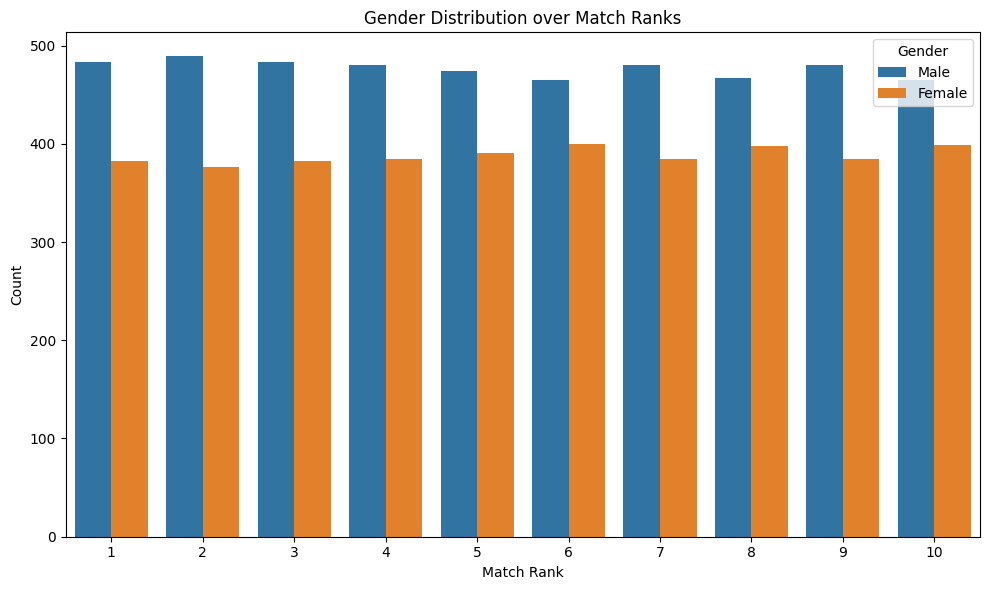

In [166]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='match_rank', hue='cand_gender', order=range(1, 11))
plt.title('Gender Distribution over Match Ranks')
plt.xlabel('Match Rank')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


Each rank reflects the hiring process unbalance, therefore the choice is arbitrary. We will chose the rank which mostly limits this bias, i.e., rank 6.

In [167]:
hired_rank = 1
negative_samples_rank = 6

In [168]:
df1 = df[df['match_rank'].isin([hired_rank,negative_samples_rank])].copy()

In [169]:
df1['hired'] = (df['match_rank'] == hired_rank).astype(int)

In [170]:
df1.drop(['match_rank'], axis=1, inplace=True)

In [174]:
df1.head()

,cand_id,job_id,distance_km,match_score,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
0,"5,664,912",OFF_1011_1427,3.232.704.163,9.957.338.715,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD,1
5,"2,216,205",OFF_1011_1427,2.494.693.947,969.223.175,Male,55-74,UD,FRIULI VENEZIA GIULIA,Degree / High School : Surveying,Subordinate employment,Surveying and technician of civil and industri...,Designers / Design / Graphics,UD,0
10,"5,025,089",OFF_1038_1739,1.778.607.559,9.994.982.147,Male,25-34,MI,LOMBARDIA,Degree / High School : Scientific High School,Search and selection,Butcher (m/f),Large-scale distribution / Retail / Shop assis...,MI,1
15,"6,111,549",OFF_1038_1739,1.818.578.529,9.991.743.469,Female,45-54,BG,LOMBARDIA,NaN,Search and selection,Butcher (m/f),Large-scale distribution / Retail / Shop assis...,MI,0
20,"7,090,323",OFF_104_1550,2.166.576.576,9.999.417.877,Male,35-44,CH,ABRUZZO,NaN,Subordinate employment,welder,Specialized workers,CH,1


## Data Preprocessing

Before continuing with the data analysis we want to ensure that missing values are handled correctly and the data are ready to be feed in a classifier. Let's inspect some of their statistics.

In [176]:
print(f'Examples in the dataset: {df1.shape[0]}')

Examples in the dataset: 1730


In [177]:
df1.describe(include='all')

,cand_id,job_id,distance_km,match_score,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,1730,1730,1730,1730,1730,1730,1729,1728,458,1730,1730,1730,1730,1730.000000
unique,1532,865,1080,1631,2,5,71,16,161,3,247,26,53,NaN
top,"7,008,813",OFF_1011_1427,0,9.999.671.936,Male,25-34,MI,LOMBARDIA,Middle School,Subordinate employment,General Metalworker,General Workers,MI,NaN
freq,7,2,119,4,948,581,278,794,84,1132,154,566,338,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500145
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Most of the variables doen't miss any value, except for the <b>candidate domicile province</b> which misses just one value, the <b>candidate domicile region</b> which misses only two values and the <b>candidate education</b>, which instead misses way more values. We can account for the 3 missing  values by simply drop the related rows, but we must find a default value for the education since the rows containing missing values are too much.

In general, we can keep all the numerical values, but we have to account for the categorical ones in order to feed a classifier. In the next paragraphs we will focus on the features that require our attention.

### IDs

Candidate id and job id are not meaningful for the task of bias detection, hence we can easily drop them.

In [114]:
df1.drop(['cand_id','job_id'], axis=1, inplace=True)

### Age Buckets

In [115]:
df1['cand_age_bucket'].unique()

array(['45-54', '35-44', '25-34', '15-24', '55-74', nan], dtype=object)

In [116]:
print(f"Null age buckets: {df1['cand_age_bucket'].isnull().sum()}")

Null age buckets: 1


Since it is only one we can safely drop it.

In [117]:
df1 = df1[~df1['cand_age_bucket'].isnull()]

In [118]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
25-34    580
35-44    430
45-54    358
55-74    210
15-24    150
Name: count, dtype: int64

We can discretize them since they are numerical but preserves the order, thus a progressive enumeration makes sense.

In [119]:
age_bucket_order = {
    '15-24': 0,
    '25-34': 1,
    '35-44': 2,
    '45-54': 3,
    '55-74': 4,
}

df1['cand_age_bucket'] = df1['cand_age_bucket'].map(age_bucket_order).astype(int)

In [120]:
df1['cand_age_bucket'].value_counts()

cand_age_bucket
1    580
2    430
3    358
4    210
0    150
Name: count, dtype: int64

,cand_id,job_id,distance_km,match_score,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,job_contract_type,job_professional_category,job_sector,job_work_province,hired
count,1729,1729,1729,1729,1729,1728,1729,1729,470,1729,1729,1729,1729,1729
unique,1547,865,1125,1637,2,5,69,15,163,3,247,26,53,2
top,"3,616,557",OFF_1011_1427,0,9.999.835.205,Male,25-34,MI,LOMBARDIA,Middle School,Subordinate employment,General Metalworker,General Workers,MI,True
freq,6,2,134,4,948,580,266,797,100,1131,154,566,338,865


### Candidate Education

In [137]:
def map_education_level(x):
    if pd.isna(x):
        return 'Unknown'
    x = str(x).lower()

    # Clean common formatting inconsistencies
    x = x.replace('laurea', 'degree')
    x = x.replace('diploma', 'degree')
    
    if 'dottorato' in x or 'phd' in x or 'research doctorate' in x:
        return 'PhD'
    elif 'master' in x or 'lm-' in x:
        return 'Graduate'
    elif 'bachelor' in x or 'l-' in x:
        return 'Undergraduate'
    elif 'higher technical institute' in x or 'its' in x:
        return 'Higher Technical Institute'
    elif 'qualification' in x or 'certificate' in x or 'operator' in x:
        return 'Vocational Certificate'
    elif 'high school' in x or 'liceo' in x or 'technician' in x or 'technical' in x:
        return 'High School'
    elif 'middle school' in x or 'scuola media' in x:
        return 'Middle School'
    elif 'elementary' in x:
        return 'Elementary School'
    else:
        return 'Other'


In [138]:
df1['cand_education'] = df1['cand_education'].apply(map_education_level)

In [139]:
df1['cand_education'].value_counts()

cand_education
Unknown                       1259
High School                    175
Vocational Certificate         102
Middle School                  100
Graduate                        38
Higher Technical Institute      30
Undergraduate                   22
Elementary School                2
PhD                              1
Name: count, dtype: int64

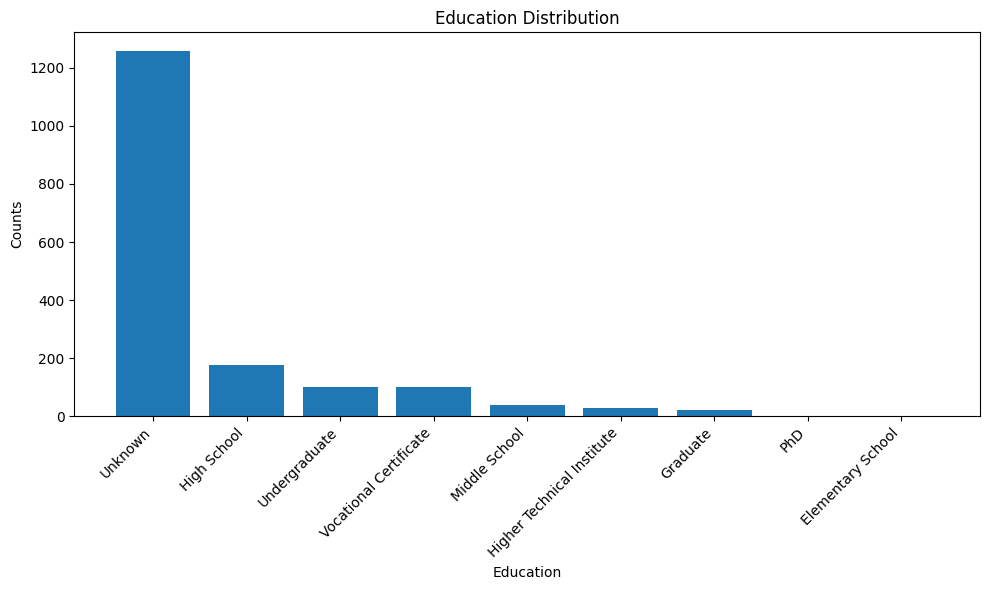

In [141]:
# Visualize the distribution
plt.figure(figsize=(10, 6))
plt.bar(df1['cand_education'].unique(), df1['cand_education'].value_counts())
plt.xlabel('Education')
plt.ylabel('Counts')
plt.title('Education Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()